# Requirements

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Problem setting

You want to perform a spatial query, i.e., you have a collection of $N$ points in 2D, and you want to find all points in a radius of $R$ around a certain location $(x, y)$.  A naive implementation would require $O(N)$ comparisons.  However, using a quad-tree data structure, this can be reduced significantly.

As a baseline, you can first implement a naive algorithm that indeed simply searches through the list of points.

# Naive implementation

In [23]:
class NaiveSearch:

    def __init__(self):
        self._elements = []

    def add(self, coords):
        self._elements.append(coords)

    def query(self, coords, radius):
        result = []
        for element in self._elements:
            if (element[0] - coords[0])**2 + (element[1] - coords[1])**2 < radius**2:
                result.append(element)
        return result

    def __len__(self):
        return len(self._elements)

    def elements(self):
        for element in self._elements:
            yield element

    def ranges(self):
        return []

In [24]:
naive = NaiveSearch()

In [25]:
naive.add((0.1, -0.3))
naive.add((0.4, 0.7))
naive.add((0.3, -0.8))

In [26]:
len(naive)

3

In [28]:
for element in naive.elements():
    print(element)

(0.1, -0.3)
(0.4, 0.7)
(0.3, -0.8)


In [29]:
naive.query((0.5, 0.3), 0.1)

[]

In [30]:
naive.query((0.15, -0.31), 0.1)

[(0.1, -0.3)]

# Quad trees

The basic idea is to add points to the rectangular domain, but as soon as their number exceeds a threshold, you split the domain into four rectangular subdomains, such that they have equal area and cover the original domain entirely.  From now on, points are added to the appropriate subdomain, splitting that in turn if the number of points it contains exceeds the threshold.  This will result in a tree structure of domains with ever decreasing sizes, each containing at most as many points as the threshold is set to.

A query will now descend from the root of the three to the leaves, but only to those relevant to the query.

In [43]:
class QuadNode:

    def __init__(self, x_range, y_range, split_threshold):
        self._x_range = x_range
        self._y_range = y_range
        self._split_threshold = split_threshold
        self._elements = []
        self._children = []

    def __len__(self):
        return len(self._elements)

    def contains(self, coords):
        return self._x_range[0] <= coords[0] < self._x_range[1] and self._y_range[0] <= coords[1] < self._y_range[1]

    @property
    def x_range(self):
        return self._x_range

    @property
    def y_range(self):
        return self._y_range

    def add(self, coords):
        if not self._children:
            self._elements.append(coords)
            if len(self) > self._split_threshold:
                self._split()
        else:
            for child in self._children:
                if child.contains(coords):
                    child.add(coords)

    def _split(self):
        x_split = 0.5*(self._x_range[0] + self._x_range[1])
        y_split = 0.5*(self._y_range[0] + self._y_range[1])
        self._children.append(QuadNode((self._x_range[0], x_split),
                                       (self._y_range[0], y_split),
                                       self._split_threshold))
        self._children.append(QuadNode((x_split, self._x_range[1]),
                                       (self._y_range[0], y_split),
                                       self._split_threshold))
        self._children.append(QuadNode((self._x_range[0], x_split),
                                       (y_split, self._y_range[1]),
                                       self._split_threshold))
        self._children.append(QuadNode((x_split, self._x_range[1]),
                                       (y_split, self._y_range[1]),
                                       self._split_threshold))
        while self._elements:
            element = self._elements.pop()
            self.add(element)

    def query(self, coords, radius):
        result = []
        if (coords[0] < self._x_range[0] - radius or
            self._x_range[1] + radius < coords[0] or
            coords[1] < self._y_range[0] - radius or
            self._y_range[1] + radius < coords[1]):
            return result
        if self._elements:
            for element in self._elements:
                distance_2 = (element[0] - coords[0])**2 + (element[1] - coords[1])**2
                if distance_2 < radius**2:
                    result.append(element)
        elif self._children:
            for child in self._children:
                result.extend(child.query(coords, radius))
        return result

    def elements(self):
        if self._elements:
            for element in self._elements:
                yield element
        elif self._children:
            for child in self._children:
                yield from child.elements()

    def ranges(self):
        all_ranges =[]
        if self._elements:
            all_ranges.append((self._x_range, self._y_range))
        elif self._children:
            for child in self._children:
                all_ranges.extend(child.ranges())
        return all_ranges

In [3]:
tree = QuadNode((-1.0, 1.0), (-1.0, 1.0), 4)

In [4]:
tree.add((0.1, -0.3))
tree.add((0.4, 0.7))
tree.add((0.3, -0.8))

In [5]:
len(tree)

3

In [6]:
for element in tree.elements():
    print(element)

(0.1, -0.3)
(0.4, 0.7)
(0.3, -0.8)


In [7]:
tree.query((0.5, 0.3), 0.1)

[]

In [8]:
tree.query((0.15, -0.31), 0.1)

[(0.1, -0.3)]

# Random points

For testing, you can define a function to generate random points in a given domain.

In [9]:
def generate_random_points(n, x_range, y_range):
    return ((random.uniform(*x_range), random.uniform(*y_range)) for _ in range(n))

# Visualization

You can writ e function that will visualize the quad tree and the points it contains, and optional a query.

In [10]:
def visualize_tree(tree, query=None):
    figure = plt.figure()
    axes = figure.add_subplot()
    axes.axes.set_xlim(tree.x_range)
    axes.axes.set_ylim(tree.y_range)
    axes.axis('equal')
    x = []
    y = []
    for element in tree.elements():
        x.append(element[0])
        y.append(element[1])
    axes.plot(x, y, '.')
    for r in tree.ranges():
        x = [r[0][0], r[0][0], r[0][1], r[0][1], r[0][0]]
        y = [r[1][0], r[1][1], r[1][1], r[1][0], r[1][0]]
        axes.plot(x, y, ':')
    if query is not None:
        circle = patches.Circle(query[0], query[1])
        circle.set_alpha(0.4)
        axes.add_patch(circle)
    plt.show()

The query, if given, will be represented by a circle with the given radius around the specified point.

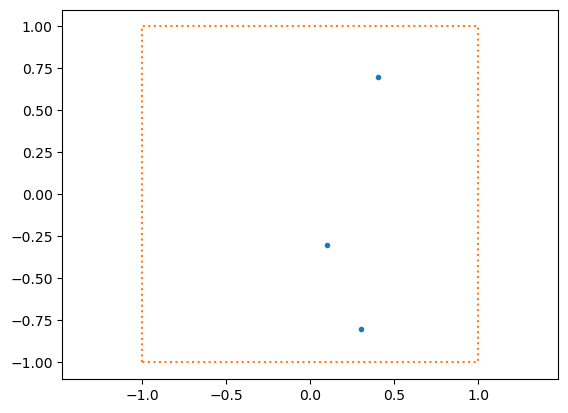

In [11]:
visualize_tree(tree)

In [12]:
tree = QuadNode((-1.0, 1.0), (-1.0, 1.0), 4)
for point in generate_random_points(50, tree.x_range, tree.y_range):
    tree.add(point)

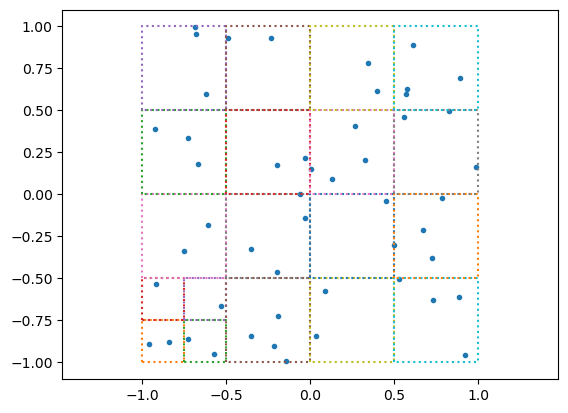

In [13]:
visualize_tree(tree)

In [14]:
query = ((-0.51, 0.51), 0.3)

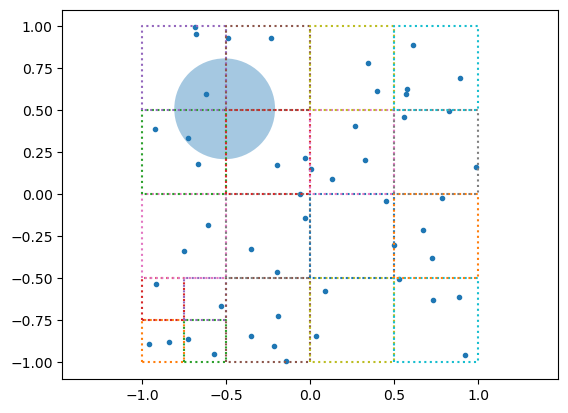

In [15]:
visualize_tree(tree, query)

In [16]:
tree.query(*query)

[(-0.7309724378648244, 0.3360414879368603),
 (-0.6194569102131231, 0.5984491619096111)]

# Testing

In [56]:
test_points = list(generate_random_points(10_000, (-1.0, 1.0), (-1.0, 1.0)))

In [58]:
query_points = list(generate_random_points(100, (-1.0, 1.0), (-1.0, 1.0)))
query_radius = 0.05

In [59]:
naive = NaiveSearch()
for point in points:
    naive.add(point)

In [60]:
tree = QuadNode((-1.0, 1.0), (-1.0, 1.0), 50)
for point in points:
    tree.add(point)

In [73]:
for point in query_points:
    assert sorted(tree.query(point, query_radius)) == sorted(naive.query(point, query_radius))

# Comparison

In [74]:
points = list(generate_random_points(100_000, (-1.0, 1.0), (-1.0, 1.0)))

In [75]:
%%timeit
naive = NaiveSearch()
for point in points:
    naive.add(point)

8.28 ms ± 861 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
%%timeit
tree = QuadNode((-1.0, 1.0), (-1.0, 1.0), 500)
for point in points:
    tree.add(point)

347 ms ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
query_points = list(generate_random_points(100, (-1.0, 1.0), (-1.0, 1.0)))

In [78]:
query_radius = 0.001

In [79]:
%%timeit
for point in query_points:
    _ = naive.query(point, query_radius)

2.97 s ± 84.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
for point in query_points:
    _ = tree.query(point, query_radius)

1.67 ms ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


For these choices of the domain size, the quad tree data structure is much faster than the naive implementation, althugh it takes longer to build.